# Determinants of Box Office Success

## Import Modules and Data

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from scipy.stats import iqr

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_csv('movie_data.csv')

## Explore and Clean Dataset

**Numeric variables:** 
- <code>num_critic_reviews</code>
- <code>duration</code>
- <code>director_facebook_likes</code>
- <code>actor_1_facebook_likes</code>
- <code>actor_2_facebook_likes</code>
- <code>actor_3_facebook_likes</code>
- <code>movie_facebook_likes</code>
- <code>gross</code>
- <code>num_users_voted (int)</code>
- <code>cast_total_facebook_likes (int)</code>
- <code>num_user_reviews</code>
- <code>budget</code>
- <code>title_year</code>
- <code>movie_score</code>
- <code>aspect_ratio (int)</code>

**Categorical variables:** 
- <code>color</code>
- <code>director_name</code>
- <code>actor_1_name</code>
- <code>actor_2_name</code>
- <code>actor_3_name</code>
- <code>genres</code>
- <code>plot_keywords</code>
- <code>language</code>
- <code>country</code>
- <code>content_rating</code>

In [3]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_reviews         4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_users_voted            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

In [4]:
# remove duplicate rows based on the 'movie_title' and 'title_year' column
movies.drop_duplicates(subset=['movie_title','title_year'], keep=False, inplace=True)

# reset index
movies.reset_index(drop=True, inplace=True)

In [5]:
# replace zeros in budget and gross columns with NaN
movies['budget'] = movies['budget'].replace(0, np.NaN)
movies['gross'] = movies['gross'].replace(0,np.NaN)

# transform budget and gross metrics to show in millions
movies['budget_millions'] = round(movies['budget'] / 1000000, 4)
movies['gross_millions'] = round(movies['gross'] / 1000000, 4)

# add calcuated columns
movies['profit_millions'] = movies['gross_millions'] - movies['budget_millions']
movies['roi'] = round((movies['profit_millions'] / movies['budget_millions']), 4)
movies['profit_margin'] = movies['profit_millions'] / movies['gross_millions']

### Remove irrelevant movies
**Challenge** - The dataset contains movies that are not relevant to the move studio's current strategy, including movies from as early as 1916 and non-English language movies.

**Solution** - filter <code>movies</code> to exclude all movies released prior to 1996 and all non-English language movies.

In [6]:
# remove all movies from before the year 1996 in order to focus on the most recent data points
movies = movies[movies['title_year']>=1996]

# keep only English language movies
movies = movies[movies['language'] == 'English']

movies.reset_index(drop=True, inplace=True)

### Explore Numeric Variables
The numeric varaibles can be divided into four categories: 
- Inputs (metrics that the movie studio can influence) 
- Non-financial metrics that represent the popularity of the actors and directors in a movie 
- Non-financial metrics of a movie’s success 
- Financial metrics of a movie’s success 

In [7]:
movies.describe()

,num_critic_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_users_voted,cast_total_facebook_likes,num_user_reviews,budget,title_year,actor_2_facebook_likes,movie_score,aspect_ratio,movie_facebook_likes,budget_millions,gross_millions,profit_millions,roi,profit_margin
count,3594.000000,3622.000000,3631.000000,3617.000000,3625.000000,3.192000e+03,3.631000e+03,3631.000000,3617.000000,3.341000e+03,3631.000000,3623.000000,3631.000000,3386.000000,3631.000000,3341.000000,3192.000000,2982.000000,2982.000000,2982.000000
mean,153.584864,105.881005,607.035527,719.228090,7353.553103,4.835620e+07,8.478490e+04,10854.106582,285.698092,3.705414e+07,2006.619664,1856.759868,6.273120,2.159338,8359.975213,37.054139,48.356203,10.205826,5.254617,-39.832713
std,125.332016,19.350855,2673.283090,1787.452942,16377.690434,6.784123e+07,1.355017e+05,19643.965493,392.308665,4.413287e+07,5.590324,4379.039825,1.099651,0.833793,21180.567963,44.132871,67.841232,51.715350,148.874059,860.296987
min,1.000000,7.000000,0.000000,0.000000,0.000000,1.620000e+02,5.000000e+00,0.000000,1.000000,2.180000e+02,1996.000000,0.000000,1.600000,1.330000,0.000000,0.000200,0.000200,-598.397500,-1.000000,-44999.000000
25%,62.000000,93.000000,8.000000,179.000000,701.000000,5.746694e+06,9.248500e+03,1752.000000,70.000000,8.000000e+06,2002.000000,352.000000,5.700000,1.850000,0.000000,8.000000,5.746675,-11.006600,-0.554300,-1.243503
50%,126.000000,102.000000,47.000000,422.000000,1000.000000,2.559138e+07,3.583400e+04,3690.000000,165.000000,2.200000e+07,2007.000000,651.000000,6.400000,2.350000,199.000000,22.000000,25.591350,0.053300,0.003850,0.003842
75%,212.000000,116.000000,181.000000,680.000000,12000.000000,6.203284e+07,9.999500e+04,15270.000000,347.000000,5.000000e+07,2011.000000,960.000000,7.000000,2.350000,5000.000000,50.000000,62.032850,21.414100,0.939725,0.484475
max,813.000000,280.000000,23000.000000,23000.000000,640000.000000,7.605058e+08,1.676169e+06,656730.000000,5060.000000,6.000000e+08,2016.000000,137000.000000,9.000000,16.000000,349000.000000,600.000000,760.505800,523.505800,7193.486700,0.999861


#### Remove outlliers
**Challenge** - After a preliminary exploration of the numeric variables, it became apparent that several of the numeric variables have significant outliers. The inclusion of outliers will make it more difficult to accurately assess relationships between variables. 

**Solution** - trim numeric variables by replacing outliers with upper whisker values.

**Method** - outliers are identified using the IQR method; replace outliers with upper whisker value; trimmed values are stored in a separate dataframe (<code>movies_trimmed</code>).

In [8]:
# define movies trimmed to hold trimmed variables
movies_trimmed = movies.copy(deep = True)

In [9]:
# separate numerical fields from categorical
movies_numeric = movies.select_dtypes(include=['float64', 'int64'])

# replace outliers with upper whisker / lower whisker value
for column in movies_numeric:
    q1 = movies_trimmed[column].quantile(0.25)
    q3 = movies_trimmed[column].quantile(0.75)
    iqr = q3 - q1
    upper_whisker = q3 + (iqr*1.5)
    lower_whisker = q1 - (iqr*1.5)
    movies_trimmed.loc[movies_trimmed[column] > upper_whisker, column] = upper_whisker
    movies_trimmed.loc[movies_trimmed[column] < lower_whisker, column] = lower_whisker

In [10]:
#boxplot = movies_trimmed.boxplot(column=['duration'])
#boxplot = movies_trimmed.boxplot(column=['movie_score'])
#boxplot = movies_trimmed.boxplot(column=['num_critic_reviews'])

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


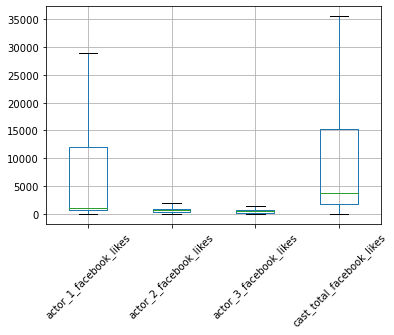

In [11]:
# boxplot showing facebook likes for actors
boxplot = movies_trimmed.boxplot(column=['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes'], rot=45)

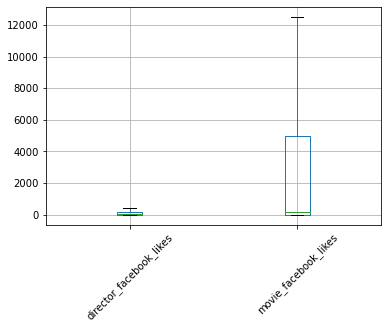

In [12]:
# boxplot showing facebook likes for directors and movies
boxplot = movies_trimmed.boxplot(column=['director_facebook_likes','movie_facebook_likes'], rot=45)

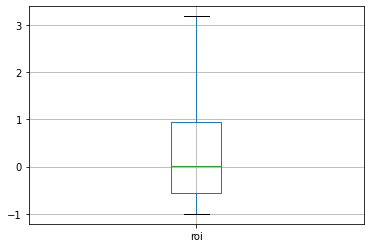

In [13]:
# boxplot showing roi
boxplot = movies_trimmed.boxplot(column=['roi'])

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


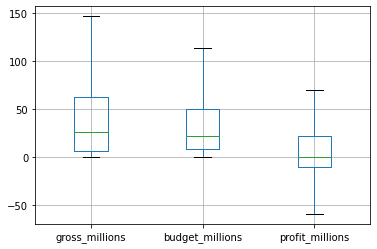

In [14]:
# boxplot showing financial variables
boxplot = movies_trimmed.boxplot(column=['gross_millions','budget_millions','profit_millions'])

In [15]:
mean_profit = movies['profit_millions'].mean()
mean_gross = movies['gross_millions'].mean()

### Explore Relationships between numeric variables

**Variables that are moderately correlated (correlation > 0.4) with gross revenue:** <code>num_critic_reviews</code>, <code>num_users_voted</code>, <code>num_user_reviews</code>, <code>budget</code>, <code>profit_millions</code>, <code>roi</code>, <code>profit_margin</code> 
<br><br>
**Variables that are moderately correlated (correlation > 0.4) with profit:** <code>gross_millions</code>, <code>num_users_voted</code>, <code>roi</code>, <code>profit_margin</code>
<br><br>
**Variables that are moderately correlated (correlation > 0.4) with profit margin:** <code>gross_millions</code>, <code>roi</code>, <code>profit_margin</code>
<br><br>
**Variables that are moderately correlated (correlation > 0.4) with ROI:** <code>gross_millions</code>, <code>profit_millions</code>, <code>profit_margin</code>

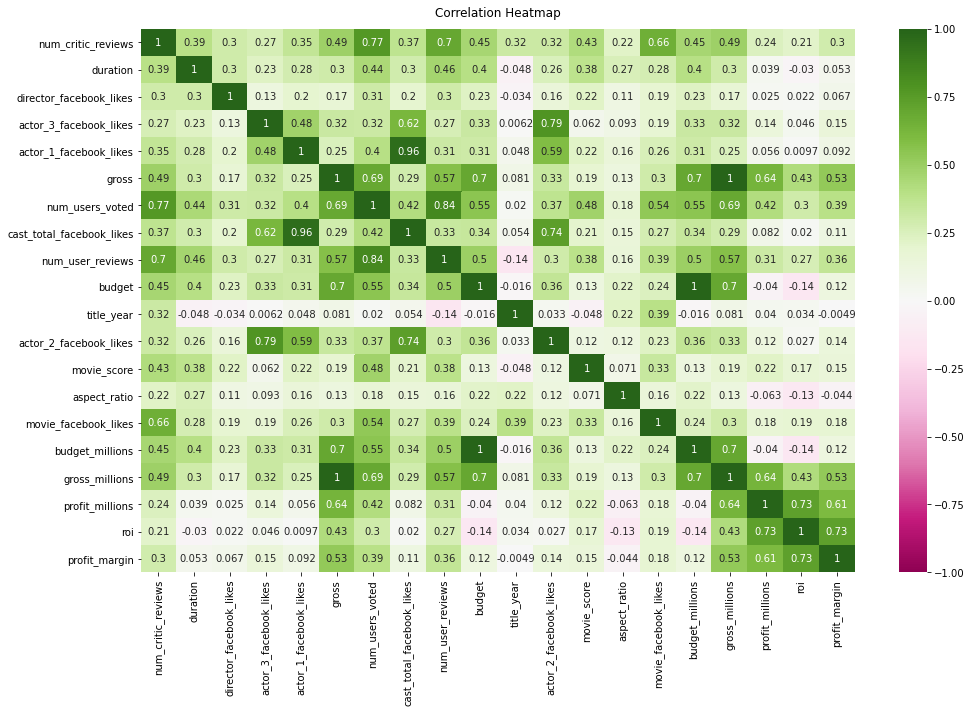

In [16]:
corr_matrix_trimmed = movies_trimmed.corr()


plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(corr_matrix_trimmed, vmin=-1, vmax=1,cmap="PiYG", annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# save correlation matrix to csv
corr_matrix_trimmed.to_csv('corr_matrix_trimmed.csv')

### Explore Categorical Variables
All of the categorical variables fit into the ‘inputs’ category (metrics that the movie studio can influence).

In [17]:
movies['director_name'].value_counts()

Steven Spielberg       15
Woody Allen            15
Clint Eastwood         14
Steven Soderbergh      13
Ridley Scott           12
                       ..
Nick Hurran             1
Thea Sharrock           1
Damien O'Donnell        1
Timothy Björklund       1
Thaddeus O'Sullivan     1
Name: director_name, Length: 1906, dtype: int64

In [18]:
movies['actor_1_name'].value_counts()

Robert De Niro    33
Matt Damon        28
J.K. Simmons      27
Nicolas Cage      27
Johnny Depp       25
                  ..
Cassie Ventura     1
Bobby Lee          1
Paul Hickert       1
Eme Ikwuakor       1
Matt Shively       1
Name: actor_1_name, Length: 1500, dtype: int64

In [19]:
movies['actor_2_name'].value_counts()

Charlize Theron        13
Morgan Freeman         13
Adam Sandler           10
Brad Pitt              10
Will Ferrell            9
                       ..
Tim Gunn                1
Alicia Keys             1
Owain Yeoman            1
Jennifer Landa          1
Kirby Bliss Blanton     1
Name: actor_2_name, Length: 2227, dtype: int64

In [20]:
movies['actor_3_name'].value_counts()

Steve Coogan       8
Stephen Root       7
Bruce McGill       6
Sam Shepard        6
Thomas Lennon      6
                  ..
Susanne Lothar     1
Amy Locane         1
Charles Baker      1
Chloe Hollings     1
Fenella Woolgar    1
Name: actor_3_name, Length: 2615, dtype: int64

In [21]:
movies['plot_keywords'].value_counts()

# plot keywords will be more effectively analyzed by separating the keywords

based on novel                                              3
one word title                                              3
two word title                                              2
after dark horrorfest                                       2
antidote|based on young adult novel|flyer|spider|vampire    1
                                                           ..
partner|running|scepter|surveillance|thief                  1
best friend|car race|conspiracy|gadget car|spy              1
arcade|candy|glitch|king|medal                              1
assassin|high school|on the run|teenager|website            1
cia|cia agent|fbi|mexico|train                              1
Name: plot_keywords, Length: 3514, dtype: int64

In [22]:
movies['country'].value_counts()

USA               2907
UK                 317
Canada              99
France              78
Germany             75
Australia           37
Spain               20
Ireland             12
New Zealand         10
South Africa         7
Denmark              6
Italy                6
Hong Kong            5
India                5
South Korea          5
China                4
Mexico               3
Japan                3
Czech Republic       2
Norway               2
Belgium              2
Thailand             2
Romania              2
Hungary              1
Poland               1
Kyrgyzstan           1
Greece               1
Aruba                1
Panama               1
Nigeria              1
Slovakia             1
Chile                1
Georgia              1
Bulgaria             1
New Line             1
Cameroon             1
Official site        1
Philippines          1
Iceland              1
Switzerland          1
Cambodia             1
Bahamas              1
Russia               1
Brazil     

In [23]:
movies['content_rating'].value_counts()

R            1598
PG-13        1223
PG            467
G              74
Not Rated      64
Unrated        26
NC-17           4
TV-PG           3
TV-G            3
TV-14           2
Name: content_rating, dtype: int64

# Analysis

For the sake of this analysis, I chose to ignore the non-monetary metrics that represent the popularity of the actors and directors in a movie - or the number of Facebook likes of the actors and directors in the movie - becaues they have weak or non-existent correlations with the monetary metrics of a movie’s success. Moreover, Facebook didn’t exist for the entire period of time we are analyzing, and the populations that use Facebook and its various features has changed dramatically over the past 15 years.  
 <br> 
I will also assume that the financial metrics of a movie’s success are most relevant to the movie studio’s decision-making processes, and therefore will not consider the non-monetary metrics of a movie’s success in the analysis.
 <br> <br>
After exploring the data through EDA, I decided to focus on 4 inputs, and two determinants of success: 
- Inputs
  - actors (<code>actor_1_name</code>, <code>actor_2_name</code>, <code>actor_3_name</code>)
  - directors (<code>director_name</code>)
  - genres (<code>genres</code>)
  - plot keywords (<code>plot_keywords</code>)
- Determinants of success
  - profit (<code>profit_millions</code>)
  - roi (<code>roi</code>)

I chose not to include profit margin(<code>profit_margin</code>) because this analysis asks me to identify which elements lead to successful movies - not cost-cutting or pricing strategies which might be better captured by profit margin. Moreover, profit margin is highly correlated with ROI, so movies with strong profit margins will likely be captured in ROI analysis.

## Actor Analysis
<br>
Do certain actors tend to make more successful movies?
<br>
<br>
I analyze the outcomes for the lead actor in a movie (<code>actor_1_name</code>) separately from the outcomes for the supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>). This method is imperfect, because some movies will have more than one headliner, and some will have ensamble casts, and this is not reflected in the data we have available. Therefore, the resulting lists of lead actors with strong financial outcomes may leave out some actors who were not coded as 'actor1' in the movies they starred in. However, this analysis will provide a strong starting point for identifying which actors appear in movies with the strongest financial outcomes.

### Profit per actor, as a percentage of average profit
Calculating profit per actor, as a percentage of average profit, normalizes the profit metric and allows for analysis of how each actor's average profit compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.

#### Lead Actor
**Method**: (1) filter df to show only actors who have appeared as the lead actor (<code>actor_1_name</code>) in at least 4 movies; (2) calculate average profit per actor; (3) divide average profit per actor by overall average profit for all movies.
<br>
<br>
**Result**: There are 48 lead actors (<code>actor_1_name</code>) with an average profit, as a percent of overall average profit greater than 2 - indicating that the movies in which these actors are the headliner (<code>actor_1_name</code>) have an average profit that is at least 100% above the overall average (a value of 1 is an average value). <br><br>
The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

In [24]:
# define value to be used to as filter
profit_baseline = 2

# actor1 - actors who have been the lead actor in at least 4 movies
# calculate number of movies per actor
actor1_counts = movies['actor_1_name'].value_counts()

# create a list that contains all actors who have appeared in at least 4 movies
actor1_list = actor1_counts[actor1_counts >= 4].index.tolist()

# filter movies df to show only actors who have appeared in at least 4 movies
actors1 = movies[movies['actor_1_name'].isin(actor1_list)]

# groupby actor; calculate average profit per actor
actor1_total = actors1.groupby(['actor_1_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor1_total['profit_pct_mean'] = (actor1_total['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than 2
actor1_profit_pct_mean = actor1_total[actor1_total['profit_pct_mean'] > profit_baseline]

actor1_profit_count = actor1_profit_pct_mean.count()
actor1_profit_count

actor_1_name       48
profit_millions    48
profit_pct_mean    48
dtype: int64

#### Supporting Actors
**Method**: (1) filter df to show only actors who have appeared as a supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>) in at least 4 movies; (2) calculate average profit per actor; (3) divide average profit per actor by overall average profit for all movies.
<br>
<br>
**Result**: There are 205 supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>) with an average profit, as a percent of overall average profit greater than 2 - indicating that the movies in which these actors play a supporting role have an average profit that is at least 100% above the overall average (a value of 1 is an average value). <br><br>
The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

In [25]:
# concatenate actor1, actor2, and actor3 columns to create df with all actors
actor1_names = movies[['actor_1_name']]
actor1_names = actor1_names.rename(columns={"actor_1_name": "names"})

actor2_names = movies[['actor_2_name']]
actor2_names = actor2_names.rename(columns={"actor_2_name": "names"})

actor3_names = movies[['actor_3_name']]
actor3_names = actor3_names.rename(columns={"actor_3_name": "names"})

actor_names = pd.concat([actor1_names, actor2_names, actor3_names])

# calculate number of movies per actor
actor_counts = actor_names['names'].value_counts()

# create a list that contains all actors who have appeared in at least 4 movies
actor_counts_lst = actor_counts[actor_counts >= 4].index.tolist()

# concatenate actor2, and actor3 columns to create df with all supporting actors
actor_supporting_names = pd.concat([actor2_names, actor3_names])

# calculate number of supporting role movies per actor
actor_supporting_counts = actor_supporting_names['names'].value_counts()

# create a list that contains all actors who have appeared in a supporting role at least 4 movies
actor_supporting_lst = actor_supporting_counts[actor_supporting_counts >= 4].index.tolist()

In [26]:
# actor 2
# filter movies df to show only actors who have appeared as a supporting actor (either actor2 or actor3) in at least 4 movies
actors2 = movies[movies['actor_2_name'].isin(actor_supporting_lst)]

# groupby actor; calculate average profit per actor
actor2_total = actors2.groupby(['actor_2_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor2_total['profit_pct_mean'] = (actor2_total['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than 2
actor2_profit_pct_mean = actor2_total[actor2_total['profit_pct_mean'] > profit_baseline]

actor2_profit_count = actor2_profit_pct_mean.count()

In [27]:
# actor3
# filter movies df to show only actors who have appeared as a supporting actor (either actor2 or actor3) in at least 4 movies
actors3 = movies[movies['actor_3_name'].isin(actor_supporting_lst)]

# groupby actor; calculate average profit per actor
actor3_total = actors3.groupby(['actor_3_name'], as_index=False)['profit_millions'].mean().sort_values(by='profit_millions', ascending=False)

# calculate difference from mean
actor3_total['profit_pct_mean'] = (actor3_total['profit_millions']/ movies['profit_millions'].mean())

# filter df to show only actors with a profit_pct_mean greater than 2
actor3_profit_pct_mean = actor3_total[actor3_total['profit_pct_mean'] > profit_baseline]

actor3_profit_count = actor3_profit_pct_mean.count()

In [28]:
# concatenate actor2 column from actor2_profit_pct_mean and actor3 column from actor3_profit_pct_mean
actor2 = actor2_profit_pct_mean[['actor_2_name']]
actor2 = actor2.rename(columns={"actor_2_name": "names"})

actor3 = actor3_profit_pct_mean[['actor_3_name']]
actor3 = actor3.rename(columns={"actor_3_name": "names"})

actors_supporting = pd.concat([actor2, actor3])

In [29]:
# drop duplicates to arrive at a list of supporting actors with a profit_pct_mean greater than 2
actors_supporting = actors_supporting.drop_duplicates()

actors_supporting_count = actors_supporting.count()
actors_supporting_count

names    205
dtype: int64

### ROI per actor, as a percentage of average ROI
Calculating ROI per actor, as a percentage of average ROI normalizes the ROI metric and allows for analysis of how each actor's average ROI compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.

#### Lead Actor
**Method**: (1) filter df to show only actors who have appeared as the lead actor (<code>actor_1_name</code>) 4 movies; (2) calculate average ROI per actor; (3) divide average ROI per actor by overall average ROI for all actors.
<br>
<br>
**Result**: There are 31 main actors (<code>actor_1_name</code>) with an average ROI, as a pct. of overall average ROI greater than 1.5 - indicating that the movies in which these actors play the lead role have an average ROI that is at least 50% above the overall average (a value of 1 is an average value). 
<br>
<br>
The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

In [30]:
roi_baseline = 1.5

# actor1
# groupby actor; calculate average roi per actor
actor1_roi = actors1.groupby(['actor_1_name'], as_index=False)['roi'].mean().sort_values(by='roi', ascending=False)

# calculate difference from mean
actor1_roi['roi_pct_mean'] = (actor1_roi['roi']/ movies['roi'].mean())

# filter df to show only actors with a profit_pct_mean greater than 1.5
actor1_roi_pct_mean = actor1_roi[actor1_roi['roi'] >= roi_baseline]

actor1_roi_count = actor1_roi_pct_mean.count()
actor1_roi_count

actor_1_name    31
roi             31
roi_pct_mean    31
dtype: int64

#### Supporting Actors
**Method**: (1) filter df to show only actors who have appeared as a supporting actor (<code>actor_2_name</code>, <code>actor_3_name</code>) in at least 4 movies; (2) calculate average ROI per actor; (3) divide average ROI per actor by overall average ROI for all actors.
<br>
<br>
**Result**: There are 105 supporting actors (<code>actor_2_name</code>, <code>actor_3_name</code>) with an average ROI, as a pct. of overall average ROI greater than 1.5 - indicating that the movies in which these actors play a supporting role have an average ROI that is at least 50% above the overall average (a value of 1 is an average value). 
<br>
<br>
The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

In [31]:
# actor2
# groupby actor; calculate average roi per actor
actor2_roi = actors2.groupby(['actor_2_name'], as_index=False)['roi'].mean().sort_values(by='roi', ascending=False)

# calculate difference from mean
actor2_roi['roi_pct_mean'] = (actor2_roi['roi']/movies['roi'].mean())

# filter df to show only actors with a profit_pct_mean greater than 1.5
actor2_roi_pct_mean = actor2_roi[actor2_roi['roi'] >= roi_baseline]

actor2_roi_count = actor2_roi_pct_mean.count()

In [32]:
# actor3
# groupby actor; calculate average roi per actor
actor3_roi = actors3.groupby(['actor_3_name'], as_index=False)['roi'].mean().sort_values(by='roi', ascending=False)

# calculate difference from mean
actor3_roi['roi_pct_mean'] = (actor3_roi['roi']/movies['roi'].mean())

# filter df to show only actors with a profit_pct_mean greater than 1.5
actor3_roi_pct_mean = actor3_roi[actor3_roi['roi'] >= roi_baseline]

actor3_roi_count = actor3_roi_pct_mean.count()

In [33]:
# concatenate actor2 column from actor2_profit_pct_mean and actor3 column from actor3_profit_pct_mean
actor2 = actor2_roi_pct_mean[['actor_2_name']]
actor2 = actor2.rename(columns={"actor_2_name": "names"})

actor3 = actor3_roi_pct_mean[['actor_3_name']]
actor3 = actor3.rename(columns={"actor_3_name": "names"})

actors_supporting = pd.concat([actor2, actor3])

# drop duplicates to arrive at a list of supporting actors with a profit_pct_mean greater than 2
actors_supporting = actors_supporting.drop_duplicates()

actors_supporting_count = actors_supporting.count()
actors_supporting_count

names    105
dtype: int64

### Summary outcomes by actor

**Method**: Analyze summary outcomes by lead actor (<code>actor_1_name</code>).
<br>
<br>
**Result**: The top actors by profit and roi have only appeared as lead actor in one or two movies and therefore will not be included in the profit per actor or ROI per actor analysis above. This indicates while the studio should aim to work with the actors identified in the previous analysis in order to seek out consistent profit, up-and-coming actor should not be ignored. Further analysis is needed to determine determinants of success for up-and-coming actors.

In [34]:
actor1_mean = movies[['actor_1_name','gross_millions','profit_millions','budget_millions','roi','movie_score','director_facebook_likes','movie_facebook_likes']].groupby(['actor_1_name']).mean()

In [35]:
#group by director; count number of movies
actor1_count = movies[['actor_1_name','color']].groupby(['actor_1_name']).count().sort_values(by='color',ascending = False)
actor1_count = actor1_count.rename(columns = {'color': 'num_movies'})

In [36]:
# merge director data into one df
actor1_df_lst = [actor1_mean, actor1_count]
actor1_df = reduce(lambda left,right: pd.merge(left,right,on='actor_1_name'), actor1_df_lst)
actor1_df = actor1_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                              'profit_millions':'avg_profit_millions',
                                              'roi':'avg_roi',
                                             'movie_score': 'avg_movie_score',
                                             'director_facebook_likes':'avg_director_fb_likes',
                                             'movie_facebook_likes':'avg_movie_fb_likes'})

actor1_df['avg_movie_score'] = round(actor1_df['avg_movie_score'],2)
actor1_df['avg_movie_fb_likes'] = round(actor1_df['avg_movie_fb_likes'],2)
#actor1_df.to_csv('actor1_df.csv')

In [37]:
# directors who directed the largest number of movies
actor1_df.sort_values(by = 'num_movies', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
actor_1_name,,,,,,,,
Robert De Niro,55.952390,14.920132,39.575758,0.504245,6.32,1622.424242,6237.45,33
Matt Damon,62.769579,9.306904,55.627778,1.924622,6.98,1375.250000,17344.71,28
Nicolas Cage,53.619232,-7.340768,57.637778,-0.197072,6.27,820.111111,5387.89,27
J.K. Simmons,70.235585,19.261511,50.974074,0.550715,6.65,286.444444,11193.11,27
Johnny Depp,104.667254,8.725417,96.312500,0.140478,6.74,1818.680000,19600.00,25
Robert Downey Jr.,101.536333,31.078000,70.458333,0.177842,6.80,1390.833333,14206.42,24
Jason Statham,45.705030,2.684422,42.478083,0.063048,6.40,706.041667,17208.33,24
Steve Buscemi,88.043988,25.818145,65.909091,0.335564,6.39,1136.458333,6488.79,24
Gerard Butler,62.900267,6.884642,60.400000,0.091889,6.56,179.681818,13065.68,22


In [38]:
# directors with top average profit
actor1_df.sort_values(by = 'avg_profit_millions', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
actor_1_name,,,,,,,,
Rupert Everett,436.47100,286.47100,150.00,1.90980,7.2,80.0,0.0,1
CCH Pounder,413.68395,253.68395,160.00,1.00725,6.8,0.0,17500.0,2
Catherine Dyer,255.95040,226.95040,29.00,7.82590,7.7,102.0,38000.0,1
Kathleen Freeman,267.65200,207.65200,60.00,3.46090,7.9,80.0,0.0,1
Phaldut Sharma,274.08500,174.08500,100.00,1.74080,7.8,0.0,147000.0,1
Ariana Richards,229.07450,156.07450,73.00,2.13800,6.5,14000.0,0.0,1
Verne Troyer,213.07920,150.07920,63.00,2.38220,6.2,116.0,0.0,1
Alexander Gould,196.76625,141.26625,55.50,1.39910,6.5,243.0,5907.0,2
Heather Donahue,140.53010,140.47010,0.06,2341.16830,6.4,19.0,0.0,1


In [39]:
# directors with top average roi
actor1_df.sort_values(by = 'avg_roi', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
actor_1_name,,,,,,,,
Micah Sloat,107.9173,107.9023,0.0150,7193.4867,6.3,110.0,12000.0,1
Greg Ayres,0.5920,0.5918,0.0002,2959.0000,7.2,20.0,754.0,1
Heather Donahue,140.5301,140.4701,0.0600,2341.1683,6.4,19.0,0.0,1
Pfeifer Brown,22.7578,22.6578,0.1000,226.5780,4.2,3.0,0.0,1
Chemeeka Walker,11.5294,11.4644,0.0650,176.3754,7.3,293.0,0.0,1
Stacy Edwards,2.8566,2.8316,0.0250,113.2640,7.3,119.0,489.0,1
John August,0.0852,0.0841,0.0011,76.4545,6.6,16.0,456.0,1
Kirk Cameron,33.4515,32.9515,0.5000,65.9030,6.5,589.0,0.0,1
Blanchard Ryan,30.5009,30.0009,0.5000,60.0018,5.7,9.0,0.0,1


## Analyze director success

Do certain director's tend to make more successful movies?

### Profit per director, as a percentage of average profit
Calculating profit per director, as a percentage of average profit normalizes the profit metric and allows for analysis of how each director's average profit compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br>
<br>
**Method**: (1) filter df to show only directors (<code>director_name</code>) who have directed at least 5 movies; (2) calculate average profit per director; (3) divide average profit per actor by overall average profit for all directors.
<br>
<br>
**Result**: There are 59 directors with average profit, as a pct. of overall average profit greater than 2 - indicating that the movies these directors direct have an average profit that is at least 100% above the overall average (a value of 1 is an average value). The actors that appear on these list have a track record of appearing in movies with above-average profit, and should be hired on future movies.

In [40]:
#calculating profit as a pct. of average profit for directors
director_counts = movies['director_name'].value_counts()

#creating a list with a condition of having appeared in at least 5 movies
director_list = director_counts[director_counts >= 5].index.tolist()

#creating a dataframe with actors in 5 or more movies
director = movies[movies['director_name'].isin(director_list)]

#creating a dataframe with actors and the average profit
director_total = director.groupby(['director_name'], as_index=False)['profit_millions'].mean().sort_values (by='profit_millions', ascending=False)

#creating the profit_pct_mean value feature
director_total['profit_pct_mean'] = (director_total['profit_millions']/ movies['profit_millions'].mean())
director_profit_pct_mean = director_total[director_total['profit_pct_mean'] > 2] 

director_profit_pct_mean_count = director_profit_pct_mean.count()
director_profit_pct_mean_count

director_name      59
profit_millions    59
profit_pct_mean    59
dtype: int64

### ROI per director, as a percentage of average ROI
Calculating ROI per director, as a percentage of average ROI normalizes the ROI metric and allows for analysis of how each director's average ROI compares to the overall average. A number greater than 1 is above average; a number less than 1 is below average.
<br>
<br>
**Method**: (1) filter df to show only directors (<code>director_name</code>) who have directed at least 5 movies; (2) calculate average ROI per director; (3) divide average ROI per actor by overall average profit for all directors.
<br>
<br>
**Result**: There are 4 directors with average ROI, as a pct. of overall average greater than 1.5 - indicating that the movies these directors direct have an average ROI that is at least 50% above the overall average (a value of 1 is an average value). The actors that appear on these list have a track record of appearing in movies with above-average ROI, and should be hired on future movies.

In [41]:
#calculating profit as a pct. of average profit for directors
director_counts = movies['director_name'].value_counts()

#creating a list with a condition of having appeared in at least 5 movies
director_list = director_counts[director_counts >= 5].index.tolist()

#creating a dataframe with actors in 5 or more movies
director = movies[movies['director_name'].isin(director_list)]

#creating a dataframe with actors and the average profit
director_total = director.groupby(['director_name'], as_index=False)['roi'].mean().sort_values (by='roi', ascending=False)

#creating the profit_pct_mean value feature
director_total['roi_pct_mean'] = (director_total['roi']/ movies['roi'].mean())
director_roi_pct_mean = director_total[director_total['roi_pct_mean'] > 1.5] 

director_roi_pct_mean_count = director_roi_pct_mean.count()
director_roi_pct_mean_count

director_name    4
roi              4
roi_pct_mean     4
dtype: int64

### Summary outcomes by director

**Method**: Analyze summary outcomes by director.
<br>
<br>
**Result**: Several of the top directors by profit and ROI have only directed one or two movies and therefore will not be included in the profit per director analysis. This indicates while the studio should aim to work with directors with a track record of financial success in order to seek out consistent profit, up-and-coming directors should not be ignored.
<br>
<br>
Further analysis is needed to determine determinants of success for up-and-coming directors.

In [42]:
#group by director; calculate average of relevant variables
directors_mean = movies[['director_name','gross_millions','profit_millions','budget_millions','roi','movie_score','director_facebook_likes','movie_facebook_likes']].groupby(['director_name']).mean()

In [43]:
#group by director; count number of movies
directors_count = movies[['director_name','color']].groupby(['director_name']).count().sort_values(by='color',ascending = False)
directors_count = directors_count.rename(columns = {'color': 'num_movies'})

In [44]:
# merge director data into one df
directors_df_lst = [directors_mean, directors_count]
directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)
directors_df = directors_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                              'profit_millions':'avg_profit_millions',
                                              'roi':'avg_roi',
                                             'movie_score': 'avg_movie_score',
                                             'director_facebook_likes':'avg_director_fb_likes',
                                             'movie_facebook_likes':'avg_movie_fb_likes'})

directors_df['avg_movie_score'] = round(directors_df['avg_movie_score'],2)
directors_df['avg_movie_fb_likes'] = round(directors_df['avg_movie_fb_likes'],2)
directors_df.to_csv('directors_df.csv')

In [45]:
# directors who directed the largest number of movies
directors_df.sort_values(by = 'num_movies', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
director_name,,,,,,,,
Woody Allen,15.347033,-1.552967,16.900000,0.033160,6.89,11000.0,10658.60,15
Steven Spielberg,133.659013,45.259013,88.400000,0.661140,7.27,14000.0,19600.00,15
Clint Eastwood,78.882093,30.896379,47.985714,0.834993,7.14,16000.0,18050.36,14
Steven Soderbergh,73.975315,29.206085,44.769231,1.462954,6.61,0.0,7510.54,13
Ridley Scott,88.017692,-2.065642,90.083333,-0.085708,7.06,0.0,27825.92,12
Robert Rodriguez,51.147064,18.056155,33.090909,0.630409,5.45,0.0,5599.09,11
Ron Howard,101.910945,18.092764,83.818182,0.152782,6.94,2000.0,12785.55,11
Bobby Farrelly,62.790950,24.064589,40.777778,1.007767,6.13,101.0,8300.00,10
Kevin Smith,25.033037,8.001788,14.525000,6.642188,6.38,0.0,4600.00,10


In [46]:
# directors with top average profit
directors_df.sort_values(by = 'avg_profit_millions', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
director_name,,,,,,,,
James Cameron,709.58905,491.089050,218.500000,2.251150,7.80,0.0,29500.00,2
Tim Miller,363.02430,305.024300,58.000000,5.259000,8.10,84.0,117000.00,1
George Lucas,388.49430,274.160967,114.333333,2.397733,6.93,0.0,7666.67,3
Kyle Balda,336.02960,262.029600,74.000000,3.540900,6.40,22.0,70000.00,1
Colin Trevorrow,328.09255,252.717550,75.375000,3.845750,7.00,365.0,90500.00,2
Chris Buck,400.73660,250.736600,150.000000,1.671600,7.60,69.0,58000.00,1
Yarrow Cheney,323.50550,248.505500,75.000000,3.313400,6.80,11.0,36000.00,1
Pierre Coffin,309.77560,237.275600,72.500000,3.243900,7.60,275.0,43500.00,2
Lee Unkrich,414.98450,214.984500,200.000000,1.074900,8.30,125.0,30000.00,1


In [47]:
# directors with top average roi
directors_df.sort_values(by = 'avg_roi', ascending = False).head(10)

,avg_gross_millions,avg_profit_millions,avg_budget_million,avg_roi,avg_movie_score,avg_director_fb_likes,avg_movie_fb_likes,num_movies
director_name,,,,,,,,
Oren Peli,107.917300,107.902300,2.507500,7193.486700,5.25,110.0,6000.00,2
Jonathan Caouette,0.592000,0.591800,0.000200,2959.000000,7.20,20.0,754.00,1
Daniel Myrick,140.530100,140.470100,0.060000,2341.168300,6.40,19.0,0.00,1
Travis Cluff,22.757800,22.657800,0.100000,226.578000,4.20,3.0,0.00,1
Alex Kendrick,26.049467,25.182800,0.655000,60.970367,6.78,589.0,2681.25,4
Shane Carruth,0.424800,0.417800,0.007000,59.685700,7.00,291.0,19000.00,1
Morgan Spurlock,13.680433,9.825433,3.855000,59.229467,6.00,293.0,0.00,3
Jared Hess,41.617400,46.169500,16.200000,55.929350,6.23,100.0,0.00,3
Neil LaBute,22.429133,7.087467,15.341667,38.032433,6.57,119.0,314.67,3


## Analzye Genre Success

**Method**: Analyze summary outcomes by genre. Movies can be classified under more than one genre; for this analysis, any movies that is classified under a genre is included in that genre's analysis. For example - a movie whose genres are "romance" and "comedy" will be included in the analyses for both genres.

In [48]:
movies['genres'].value_counts()

Comedy                                             169
Drama                                              164
Comedy|Drama                                       154
Comedy|Drama|Romance                               148
Comedy|Romance                                     139
                                                  ... 
Comedy|Drama|Mystery|Romance|Thriller                1
Action|Adventure|Family|Fantasy|Sci-Fi|Thriller      1
Action|Adventure|Animation|Family                    1
Action|Drama|Mystery|Sci-Fi                          1
Adventure|Comedy|Family|Fantasy|Horror|Mystery       1
Name: genres, Length: 731, dtype: int64

In [49]:
# add binary genre variable to movies df

#create list of genres
genre_lst = ['Action','Adventure','Animation','Comedy','Crime','Documentary','Drama','Family','Fantasy','Music','Mystery','Thriller','Horror','Romance','Sci-Fi']

# create column for each genre in genre_lst
for x in genre_lst:
    movies['genre_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies['genres'])):
    for y in genre_lst:
        if y in movies['genres'][x]:
            movies['genre_' + y.lower()][x] = y.lower()
        else:
            movies['genre_' + y.lower()][x] = 'not ' + y.lower()

c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\kspanos\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [63]:
# create df to analyze count by genre
genre_count = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).count()
    x = x.rename_axis('genre', axis= 0)
    genre_count = genre_count.append(x)

genre_count = genre_count[genre_count.index.str.contains("not")==False]
genre_count['pct_total']= genre_count['color'] / genre_count['color'].sum()

genre_count = genre_count[['color','pct_total']].copy()
genre_count.rename(columns={"color": "count"})

genre_count

,color,pct_total
genre,,
action,791,0.081404
adventure,615,0.063291
animation,194,0.019965
comedy,1460,0.150252
crime,640,0.065864
documentary,103,0.010600
drama,1813,0.186580
family,419,0.043120
fantasy,418,0.043017


### Average outcome by genre

In [59]:
# create df to analyze average outcome by genre
genre_avg = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).mean()
    x = x.rename_axis('genre', axis= 0)
    genre_avg = genre_avg.append(x)

genre_avg = genre_avg[genre_avg.index.str.contains("not")==False]

genre_avg = genre_avg[['budget_millions','gross_millions','profit_millions','roi']]

genre_avg

,budget_millions,gross_millions,profit_millions,roi
genre,,,,
action,67.647873,80.109331,7.406759,0.142374
adventure,84.330275,102.900651,16.790618,0.382039
animation,81.286702,109.828187,25.892274,0.444599
comedy,33.623446,47.929497,14.500878,1.111212
crime,31.818620,37.491894,4.837784,0.251857
documentary,4.894068,12.128262,6.630271,56.924669
drama,27.970061,33.243072,5.343215,1.063906
family,65.333377,87.231641,20.085309,0.599959
fantasy,70.834450,88.529675,16.207542,0.469444


In [77]:
# merge genre count and genre average outcome data into one df
genre_df_lst = [genre_avg, genre_count]

#directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)

genre_avg_df = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), genre_df_lst)
genre_avg_df = genre_df.rename(columns = {'gross_millions': 'avg_gross_millions',
                                             'budget_millions': 'avg_budget_million',
                                              'profit_millions':'avg_profit_millions',
                                              'roi':'avg_roi',
                                     'color':'total_num'})

genre_avg_df

#genre_df.to_csv('genre_df.csv')

,avg_budget_million,avg_gross_millions,avg_profit_millions,avg_roi,total_num,pct_total
genre,,,,,,
action,67.647873,80.109331,7.406759,0.142374,791,0.081404
adventure,84.330275,102.900651,16.790618,0.382039,615,0.063291
animation,81.286702,109.828187,25.892274,0.444599,194,0.019965
comedy,33.623446,47.929497,14.500878,1.111212,1460,0.150252
crime,31.818620,37.491894,4.837784,0.251857,640,0.065864
documentary,4.894068,12.128262,6.630271,56.924669,103,0.010600
drama,27.970061,33.243072,5.343215,1.063906,1813,0.186580
family,65.333377,87.231641,20.085309,0.599959,419,0.043120
fantasy,70.834450,88.529675,16.207542,0.469444,418,0.043017


#### barplot - average gross by genre

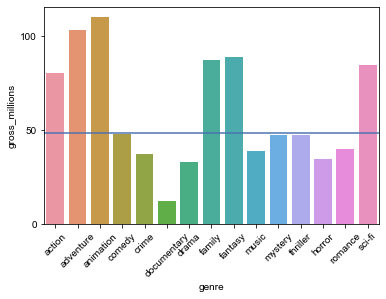

In [51]:
plt.clf()
genre_avg_gross = sns.barplot(x= genre_avg.index, y="gross_millions", data=genre_avg)
genre_avg_gross.set_xticklabels(genre_avg_gross.get_xticklabels(),rotation=45)
genre_avg_gross.axhline(mean_gross)
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=2)

#plt.savefig('genre_avg_gross.png')

#### barplot - average profit by genre

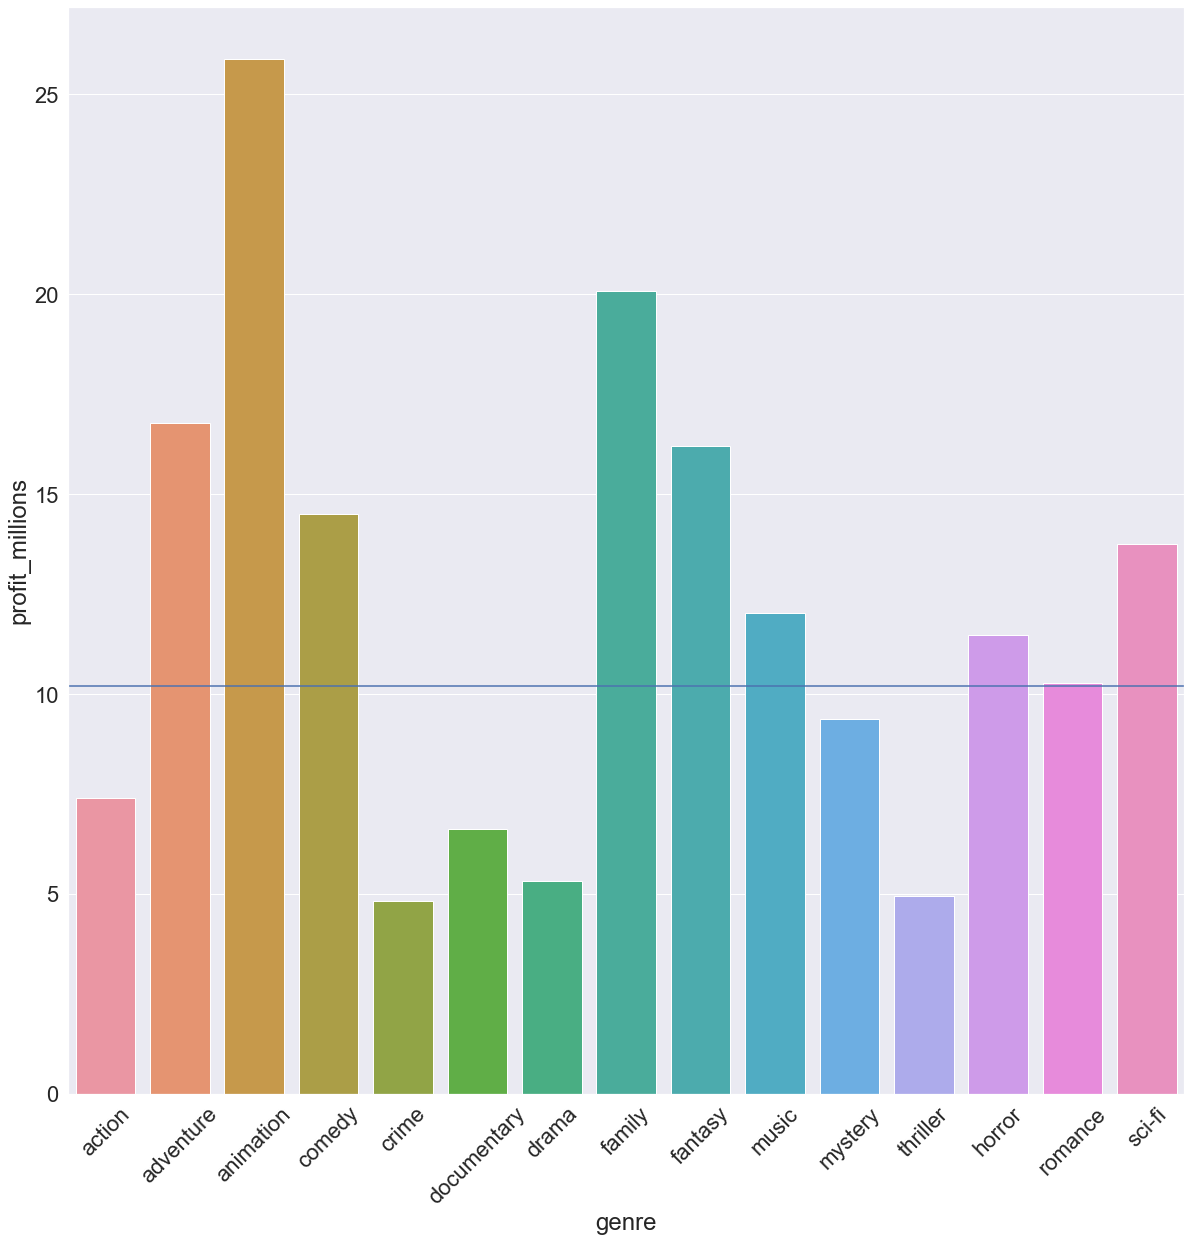

In [52]:
plt.clf()
genre_avg_profit = sns.barplot(x= genre_avg.index, y="profit_millions", data=genre_avg)
genre_avg_profit.set_xticklabels(genre_avg_profit.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(10,10)})
sns.set(font_scale=2)
genre_avg_profit.axhline(mean_profit)

#plt.savefig('genre_avg_profit.png')

### Total outcome (sum) by genre

In [62]:
genre_sum = pd.DataFrame()
for x in genre_lst:
    x = movies.groupby(['genre_' + x.lower()]).sum()
    x = x.rename_axis('genre', axis= 0)
    genre_sum = genre_sum.append(x)

genre_sum = genre_sum[genre_sum.index.str.contains("not")==False]
genre_sum = genre_sum[['budget_millions','gross_millions','profit_millions']]

genre_sum

,budget_millions,gross_millions,profit_millions
genre,,,
action,52156.5100,56957.7346,5184.7316
adventure,50598.1650,60196.8807,9654.6053
animation,15281.9000,19769.0736,4582.9325
comedy,45223.5352,64321.3845,18097.0954
crime,19377.5398,21782.7904,2670.4566
documentary,396.4195,970.2610,384.5557
drama,46010.7508,53920.2620,7945.3610
family,26198.6840,33933.1085,7531.9909
fantasy,28333.7800,34349.5139,6142.6583


In [80]:
# merge genre count and genre average outcome data into one df
genre_df_lst = [genre_sum, genre_count]

#directors_df = reduce(lambda left,right: pd.merge(left,right,on='director_name'), directors_df_lst)

genre_sum_df = reduce(lambda left,right: pd.merge(left, right, left_index=True, right_index=True), genre_df_lst)
genre_sum_df = genre_sum_df.rename(columns = {'gross_millions': 'total_gross_millions',
                                             'budget_millions': 'total_budget_million',
                                              'profit_millions':'total_profit_millions',
                                     'color':'total_num'})

genre_sum_df

#genre_df.to_csv('genre_df.csv')

,total_budget_million,total_gross_millions,total_profit_millions,total_num,pct_total
genre,,,,,
action,52156.5100,56957.7346,5184.7316,791,0.081404
adventure,50598.1650,60196.8807,9654.6053,615,0.063291
animation,15281.9000,19769.0736,4582.9325,194,0.019965
comedy,45223.5352,64321.3845,18097.0954,1460,0.150252
crime,19377.5398,21782.7904,2670.4566,640,0.065864
documentary,396.4195,970.2610,384.5557,103,0.010600
drama,46010.7508,53920.2620,7945.3610,1813,0.186580
family,26198.6840,33933.1085,7531.9909,419,0.043120
fantasy,28333.7800,34349.5139,6142.6583,418,0.043017


#### barplot - total gross by genre

In [ ]:
genre_sum_gross = sns.barplot(x= genre_sum.index, y="gross_millions", data=genre_sum)
genre_sum_gross.set_xticklabels(genre_sum_gross.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale=2)

#plt.savefig('genre_sum_gross.png')

#### barplot - total profit by genre

In [ ]:
genre_sum_revenue = sns.barplot(x= genre_sum.index, y="profit_millions", data=genre_sum)
genre_sum_revenue.set_xticklabels(genre_sum_revenue.get_xticklabels(),rotation=45)
sns.set(rc={'figure.figsize':(20,15)})
sns.set(font_scale=2)

#plt.savefig('genre_sum_profit.png')

## Keyword Analysis

Analyze which keywords are associated with stronger outcomes.
<br>
<br>
**Method**: (1) filter df to show only keywords that are associated with at least 30 movies; (2) calculate average outcomes per keyword.
<br>
<br>
**Result**: There are 44 keywords with an average profit greater than 2, and/or an average ROI greater than 1.5. These topics have a track record of strong outcomes. Therefore, future movies should focus their plots on these topics.

In [ ]:
# create list of plot keywords
movies['plot_keywords'] = movies['plot_keywords'].astype(str)
lst = movies['plot_keywords'].tolist()

# define empty list
lst_keywords = []

# split keywords on |; append keywords to lst_keywords
for i in lst:
    lst_keywords.append(i.split('|'))

# define function to flatten list of lists into one list (function pulled from stack overflow: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists)
def flatten(t):
    return [item for sublist in t for item in sublist]

# apply flatten() to lst_keywords to create list of all keywords
keywords = pd.DataFrame(flatten(lst_keywords),columns=['keywords'])

In [ ]:
#calculate value counts for each keyword
keyword_counts = keywords['keywords'].value_counts()

#create a list of keywords that are associated with at least 50 movies
keyword_lst = keyword_counts[keyword_counts >= 30].index.tolist()

#create a dataframe with keywords associated with 50 or more movies
keyword = movies[movies['plot_keywords'].isin(keyword_list)]

In [ ]:
# add binary keyword variable to movies df
movies_kw = movies

# create column for each genre in genre_lst
for x in keyword_lst:
    movies_kw['keyword_' + x.lower()] = ""

# populate columns with binary field
for x in range(len(movies_kw['plot_keywords'])):
    for y in keyword_lst:
        if y in movies_kw['plot_keywords'][x]:
            movies_kw['keyword_' + y.lower()][x] = y.lower()
        else:
            movies_kw['keyword_' + y.lower()][x] = 'not ' + y.lower()

### Create df to analyze average outcome by keyword

In [ ]:
kw_avg = pd.DataFrame()
for x in keyword_lst:
    x = movies.groupby(['keyword_' + x.lower()]).mean()
    x = x.rename_axis('keyword', axis= 0)
    kw_avg = kw_avg.append(x)

kw_avg = kw_avg[kw_avg.index.str.contains("not")==False]

In [ ]:
top_keywords_profit = kw_avg[kw_avg['profit_millions'] > 2]

top_keywords_profit_lst = top_keywords_profit.index.tolist()

In [ ]:
top_keywords_roi = kw_avg[kw_avg['roi'] > 1.5]

top_keywords_roi_lst = top_keywords_roi.index.tolist()

In [ ]:
top_keywords = pd.concat([top_keywords_profit, top_keywords_roi])

# drop duplicates to arrive at a list of supporting actors with a profit_pct_mean greater than 2
top_keywords = top_keywords.drop_duplicates()

keywords_count = keywords.count()

# Ideas for additional analysis

How successful are sequels and series'?
<br>
Closer look at popular groupings of genres (i.e. romance and comedy; action and adventure)
<br>
Analysis of whether or not facebook likes predict actor success
<br>
Analysis of outcomes by content rating